# Iris Dataset Classification Using Logistic Regression

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris-flower-dataset/IRIS.csv


In [2]:
iris_dataset = pd.read_csv('/kaggle/input/iris-flower-dataset/IRIS.csv')

## Looking at the Data

In [3]:
iris_dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
iris_dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
iris_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
iris_dataset.groupby('species').agg(['mean', 'std'])

sepal_length           sepal_width           petal_length  \
                        mean       std        mean       std         mean   
species                                                                     
Iris-setosa            5.006  0.352490       3.418  0.381024        1.464   
Iris-versicolor        5.936  0.516171       2.770  0.313798        4.260   
Iris-virginica         6.588  0.635880       2.974  0.322497        5.552   

                          petal_width            
                      std        mean       std  
species                                          
Iris-setosa      0.173511       0.244  0.107210  
Iris-versicolor  0.469911       1.326  0.197753  
Iris-virginica   0.551895       2.026  0.274650

## Performing Multi-Class Logistic Regression

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
logistic_regression = LogisticRegression(multi_class='multinomial',
                                        solver='saga',
                                        penalty='l1', max_iter = 1000)
pipe = Pipeline(steps = [("scaler", scaler), ("logistic_regression", logistic_regression)])
X_train, X_test, y_train, y_test = train_test_split(iris_dataset[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']],
                                                    iris_dataset['species'], test_size = 0.25, random_state=42)
predictor = pipe.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
y_pred_prob = predictor.predict_proba(X_test)

## Analysing the Model: Precision, Recall, F1 Score

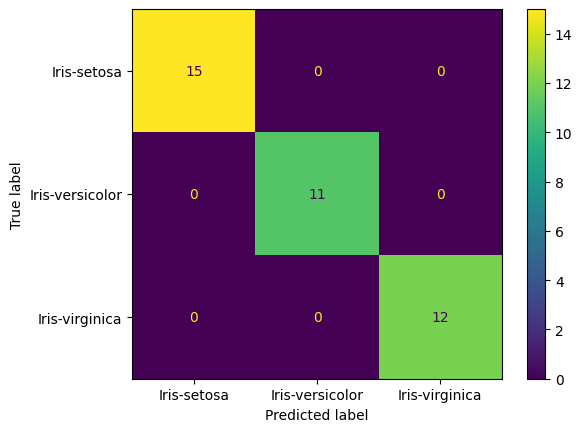

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, 
                                        labels = iris_dataset['species'].unique()),
                       display_labels = iris_dataset['species'].unique()).plot(); # confusion matrix

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, 
                     y_pred,
                     labels = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'],
                     target_names = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica']))

                 precision    recall  f1-score   support

Iris-versicolor       1.00      1.00      1.00        11
    Iris-setosa       1.00      1.00      1.00        15
 Iris-virginica       1.00      1.00      1.00        12

       accuracy                           1.00        38
      macro avg       1.00      1.00      1.00        38
   weighted avg       1.00      1.00      1.00        38



In [10]:
from sklearn.metrics import roc_auc_score
# the AUC-ROC, another metric that measures the overall performance of a classifier.
roc_auc_score(y_test, predictor.predict_proba(X_test),
             average='macro', multi_class='ovr')

1.0